In [73]:
import torch
from torch import nn
from torchviz import make_dot
import numpy as np
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split
import time
import pickle

# if data is too big -- uncomment
# alt.data_transformers.enable("json")

dev = torch.device("cuda")  # change to "cpu" if you have no NVIDIA GPU


def batch(x, y, n=1):
    """
    Batches generator. Generates tuples data-labels of length n. 
    The last batch may be shorter.
    """
    if len(x) != len(y):
        raise TypeError("Mismatch lengths")
    l = len(x)
    for ndx in range(0, l, n):
        yield (x[ndx : min(ndx + n, l)], y[ndx : min(ndx + n, l)])
        

class ConvNet(nn.Module):
    def __init__(self, outch1, outch2, kheight, kwidth, pretrained_state_dict=None):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, outch1, kernel_size=(kheight, kwidth)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(10, 1), stride=8),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(outch1, outch2, kernel_size=(kheight, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(14, 1), stride=8),
        )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Sequential(nn.Linear(2048, 1632), nn.ReLU())
        self.fc2 = nn.Linear(1632, 2)
        if pretrained_state_dict:
            self.load_state_dict(pretrained_state_dict)

    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = out.reshape(out.size(0), -1)
        # print(out.shape)
        out = self.drop_out(out)
        if out.shape[1] != self.fc1[0].in_features:
            print("!!!Automatic linear layer reshaping!!!")
            self.fc1 = nn.Sequential(nn.Linear(out.shape[1], 1632), nn.ReLU()).to(dev)
        out = self.fc1(out)
        # print(out.shape)
        out = self.fc2(out)
        return out

In [74]:
num_epochs = 40  # number of epochs to learn
batch_size = 100  # batch size. High value may lead to memory overflow

# load datasets
x, y = (np.load("ncRNApair_data.npy"), np.load("ncRNApair_labe.npy"))  # data  # labels
# splitting data
x, x_test, y, y_test = train_test_split(x, y, test_size=0.05)
train_set = list(
    map(
        lambda k: (
            torch.Tensor(k[0].reshape(k[0].shape[0], 1, k[0].shape[1], k[0].shape[2])),
            torch.Tensor(k[1]).long(),
        ),
        batch(x, y, batch_size),
    )
)
# init test tensors
taln, tlab = (
    torch.Tensor(
        x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
    ).to(device=dev),
    torch.Tensor(y_test).long().to(device=dev),
)

# init model and training components
width = x.shape[2]
model = ConvNet(64, 128, 15, width).to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.07, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 100, 1, 0.0001
)

In [75]:
# training cycle and traking some stats
total_step = len(train_set)  # steps in epoch
lr_list = []
loss_list = []
acc_list = []
epoch_loss = []
epoch_acc = []
val_epoch_loss = []
val_epoch_acc = []
start = time.time()
for epoch in range(num_epochs):
    # training
    for i, (alns, labels) in enumerate(train_set):
        # Forward propagation
        alns = alns.to(device=dev)
        labels = labels.to(device=dev)
        outputs = model(alns)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backpropagation, optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy tracking
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
        lr_list.append(scheduler.get_lr()[0])
        scheduler.step()
    epoch_loss.append(np.average(loss_list[-total_step:]))
    epoch_acc.append(np.average(acc_list[-total_step:]))

    # Epoch validation (acc/loss)
    outputs = model(taln)
    loss = criterion(outputs, tlab)
    val_epoch_loss.append(loss.item())
    total = tlab.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == tlab).sum().item()
    sens = torch.min(predicted, tlab).sum().item() / predicted.sum().item()
    val_epoch_acc.append(correct / total)
    print(
        "Epoch [{}/{}], Loss (train/val): {:.4f}/{:.4f}, Accuracy (train/val): {:.2f}%/{:.2f}%, Sensitivity (val): {:.2f}, Current lr: {:.5f}. Time elapsed: {:.2f}".format(
            epoch + 1,
            num_epochs,
            epoch_loss[-1],
            val_epoch_loss[-1],
            epoch_acc[-1] * 100,
            val_epoch_acc[-1] * 100,
            sens,
            scheduler.get_lr()[0],
            time.time() - start,
        )
    )
    with open("pretrained_model_ep{}.pcl".format(epoch), "wb") as fout:
        pickle.dump(model.state_dict(), fout)

!!!Automatic linear layer reshaping!!!
Epoch [1/40], Loss (train/val): 0.4867/0.4393, Accuracy (train/val): 82.85%/84.27%, Sensitivity (val): 0.84, Current lr: 0.06568. Time elapsed: 0.58
Epoch [2/40], Loss (train/val): 0.4244/0.4233, Accuracy (train/val): 84.79%/84.27%, Sensitivity (val): 0.84, Current lr: 0.05284. Time elapsed: 1.11
Epoch [3/40], Loss (train/val): 0.4116/0.4125, Accuracy (train/val): 84.79%/84.27%, Sensitivity (val): 0.84, Current lr: 0.03505. Time elapsed: 1.64
Epoch [4/40], Loss (train/val): 0.4032/0.4076, Accuracy (train/val): 84.79%/84.27%, Sensitivity (val): 0.84, Current lr: 0.01726. Time elapsed: 2.17
Epoch [5/40], Loss (train/val): 0.3987/0.4031, Accuracy (train/val): 84.79%/84.27%, Sensitivity (val): 0.84, Current lr: 0.00442. Time elapsed: 2.89
Epoch [6/40], Loss (train/val): 0.3959/0.3966, Accuracy (train/val): 84.79%/84.27%, Sensitivity (val): 0.84, Current lr: 0.06998. Time elapsed: 3.43
Epoch [7/40], Loss (train/val): 0.3898/0.3869, Accuracy (train/val)

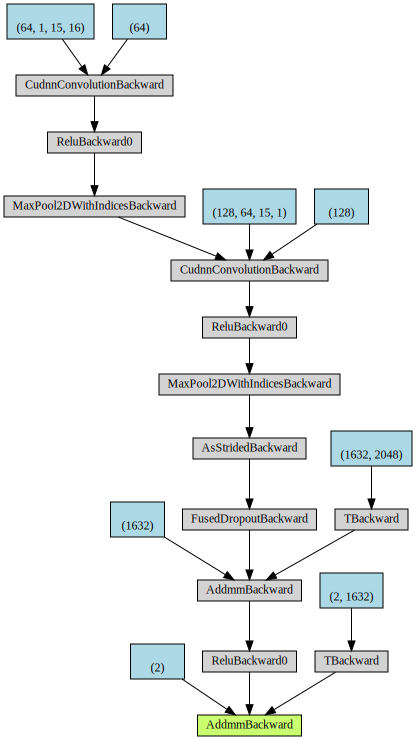

In [65]:
make_dot(
    model(torch.Tensor(x[0]).reshape(1, 1, x[0].shape[0], x[0].shape[1]).to(dev))
)  # visualistion of NN

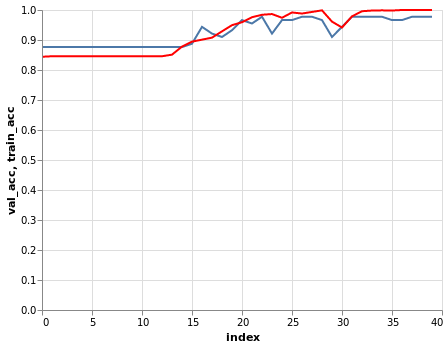

In [72]:
acc = (
    alt.Chart(pd.DataFrame({"val_acc": val_epoch_acc}).reset_index())
    .mark_line()
    .encode(alt.X("index"), alt.Y("val_acc"))
)
tacc = (
    alt.Chart(pd.DataFrame({"train_acc": epoch_acc}).reset_index())
    .mark_line(color="red")
    .encode(alt.X("index"), alt.Y("train_acc"))
)
acc + tacc